# load cudf

# import

In [1]:
%load_ext cudf.pandas

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from optuna.trial import Trial
from sklearn.model_selection import KFold
import time


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (21, 9)
plt.rcParams['figure.dpi'] = 300
plt.style.use('dark_background')

# read data

In [118]:
COLUMNS=[
    'manufacturer',
    'model',
    'vehicle_condition',
    'battery_capacity',
    'drivetrain',
    'mileage',
    'warranty_period',
    'accident_history',
    'year_of_manufacture',
]
SEED = 42

In [119]:
train = pd.read_csv('./data/train.csv')
train = train.drop(columns=['ID'])
train.columns = COLUMNS + ['y']
train.manufacturer = train.manufacturer.str.replace('사', '_corp')

test = pd.read_csv('./data/test.csv')
test = test.drop(columns=['ID'])
test.columns = COLUMNS
test_X = test
test_X.manufacturer = test_X.manufacturer.str.replace('사', '_corp')

In [120]:
train

,manufacturer,model,vehicle_condition,battery_capacity,drivetrain,mileage,warranty_period,accident_history,year_of_manufacture,y
0,P_corp,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,K_corp,Niro,Nearly New,56.0,FWD,10199,6,No,0,28.01
2,A_corp,eT,Brand New,91.2,AWD,2361,7,No,0,66.27
3,A_corp,RSeTGT,Nearly New,<NA>,AWD,21683,3,No,0,99.16
4,B_corp,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02
...,...,...,...,...,...,...,...,...,...,...
7492,H_corp,ION5,Brand New,<NA>,AWD,3773,10,No,0,35.95
7493,B_corp,i3,Pre-Owned,46.0,RWD,135411,2,No,0,23.40
7494,P_corp,TayCT,Brand New,<NA>,AWD,1363,2,No,0,120.00
7495,B_corp,i3,Nearly New,56.0,RWD,39445,6,No,2,24.00


### Fillna

In [121]:
train['battery_capacity'] = train['battery_capacity'].fillna(0)
test['battery_capacity'] = test['battery_capacity'].fillna(0)

In [122]:
combined = pd.concat([train,test], axis=0, ignore_index=True)
FEATURES = combined.columns.drop("y")
CATS = []
HIGH_CARDINALITY = []

In [123]:
print(f"THE {len(FEATURES)} BASIC FEATURES ARE:")
for c in FEATURES:
    ftype = "numerical"
    if combined[c].dtype=="object":
        CATS.append(c)
        combined[c] = combined[c].fillna("NAN")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        ftype = "categorical"
    if combined[c].dtype=="int64":
        combined[c] = combined[c].astype("int32")
    elif combined[c].dtype=="float64":
        combined[c] = combined[c].astype("float32")
        
    n = combined[c].nunique()
    print(f"{c} ({ftype}) with {n} unique values")
    if n>=25: HIGH_CARDINALITY.append(c)
    
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

THE 9 BASIC FEATURES ARE:
manufacturer (categorical) with 7 unique values
model (categorical) with 21 unique values
vehicle_condition (categorical) with 3 unique values
battery_capacity (numerical) with 203 unique values
drivetrain (categorical) with 3 unique values
mileage (numerical) with 7633 unique values
warranty_period (numerical) with 11 unique values
accident_history (categorical) with 2 unique values
year_of_manufacture (numerical) with 3 unique values


In [124]:
train

,manufacturer,model,vehicle_condition,battery_capacity,drivetrain,mileage,warranty_period,accident_history,year_of_manufacture,y
0,0,0,0,86.077003,0,13642,0,0,2,159.66
1,1,1,0,56.000000,1,10199,6,0,0,28.01
2,2,2,1,91.199997,0,2361,7,0,0,66.27
3,2,3,0,0.000000,0,21683,3,0,0,99.16
4,3,4,2,61.018002,0,178205,1,0,0,62.02
...,...,...,...,...,...,...,...,...,...,...
7492,4,19,1,0.000000,0,3773,10,0,0,35.95
7493,3,18,2,46.000000,2,135411,2,0,0,23.40
7494,0,10,1,0.000000,0,1363,2,0,0,120.00
7495,3,18,0,56.000000,2,39445,6,0,2,24.00


# TE

In [126]:
# milage qcut bin
# train.mileage = pd.qcut(train['mileage'], 20, labels=False)

In [131]:
def target_encode(train, valid, test, col, target="y", kfold=5, smooth=20, agg="mean"):
    train['kfold'] = ((train.index) % kfold)
    col_name = '_'.join(col)
    train[f'TE_{agg.upper()}_' + col_name] = 0.
    for i in range(kfold):
        
        df_tmp = train[train['kfold']!=i]
        if agg=="mean": mn = train[target].mean()
        elif agg=="median": mn = train[target].median()
        elif agg=="min": mn = train[target].min()
        elif agg=="max": mn = train[target].max()
        elif agg=="nunique": mn = 0
        df_tmp = df_tmp[col + [target]].groupby(col).agg([agg, 'count']).reset_index()
        df_tmp.columns = col + [agg, 'count']
        if agg=="nunique":
            df_tmp['TE_tmp'] = df_tmp[agg] / df_tmp['count']
        else:
            df_tmp['TE_tmp'] = ((df_tmp[agg]*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
        df_tmp_m = train[col + ['kfold', f'TE_{agg.upper()}_' + col_name]].merge(df_tmp, how='left', left_on=col, right_on=col)
        df_tmp_m.loc[df_tmp_m['kfold']==i, f'TE_{agg.upper()}_' + col_name] = df_tmp_m.loc[df_tmp_m['kfold']==i, 'TE_tmp']
        train[f'TE_{agg.upper()}_' + col_name] = df_tmp_m[f'TE_{agg.upper()}_' + col_name].fillna(mn).values  
    
    df_tmp = train[col + [target]].groupby(col).agg([agg, 'count']).reset_index()
    if agg=="mean": mn = train[target].mean()
    elif agg=="median": mn = train[target].median()
    elif agg=="min": mn = train[target].min()
    elif agg=="max": mn = train[target].max()
    elif agg=="nunique": mn = 0
    df_tmp.columns = col + [agg, 'count']
    if agg=="nunique":
        df_tmp['TE_tmp'] = df_tmp[agg] / df_tmp['count']
    else:
        df_tmp['TE_tmp'] = ((df_tmp[agg]*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
    df_tmp_m = valid[col].merge(df_tmp, how='left', left_on=col, right_on=col)
    valid[f'TE_{agg.upper()}_' + col_name] = df_tmp_m['TE_tmp'].fillna(mn).values
    valid[f'TE_{agg.upper()}_' + col_name] = valid[f'TE_{agg.upper()}_' + col_name].astype("float32")

    df_tmp_m = test[col].merge(df_tmp, how='left', left_on=col, right_on=col)
    test[f'TE_{agg.upper()}_' + col_name] = df_tmp_m['TE_tmp'].fillna(mn).values
    test[f'TE_{agg.upper()}_' + col_name] = test[f'TE_{agg.upper()}_' + col_name].astype("float32")

    train = train.drop('kfold', axis=1)
    train[f'TE_{agg.upper()}_' + col_name] = train[f'TE_{agg.upper()}_' + col_name].astype("float32")

    return(train, valid, test)

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

model = CatBoostRegressor(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=SEED,
    # gpu
    task_type="GPU",
    devices='0',
    verbose=0
)
x_train, x_valid = train_test_split(train, test_size=0.2, random_state=SEED)
model.fit(x_train[FEATURES], x_train['y'], cat_features=CATS, eval_set=(x_valid[FEATURES], x_valid['y']), verbose=0)

In [ ]:
best = root_mean_squared_error()
lists2 = []
BASIC9 = train.columns.drop(['y'])


In [ ]:
FOLDS = 5

kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof = np.zeros(len(train))
pred = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES+["y"] ].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    start = time.time()
    print(f"FEATURE ENGINEER {len(FEATURES)} COLUMNS and {len(lists2)} GROUPS: ",end="")
    for j,f in enumerate(FEATURES+lists2):

        if j<len(FEATURES): c = [f]
        else: c = f 
        print(f"({j+1}){c}",", ",end="")

        # LOW CARDINALITY FEATURES - TARGET ENCODE MEAN AND MEDIAN
        x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=20, agg="mean")
        x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="median")

        # HIGH CARDINALITY FEATURES - TE MIN, MAX, NUNIQUE and CE
        if (j>=len(FEATURES)) | (c[0] in HIGH_CARDINALITY):
            x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="min")
            x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="max")
            x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="nunique")
    
            # COUNT ENCODING (USING COMBINED TRAIN TEST)
            tmp = combined.groupby(c).y.count()
            nm = f"CE_{'_'.join(c)}"; tmp.name = nm
            x_train = x_train.merge(tmp, on=c, how="left")
            x_valid = x_valid.merge(tmp, on=c, how="left")
            x_test = x_test.merge(tmp, on=c, how="left")
            x_train[nm] = x_train[nm].astype("int32")
            x_valid[nm] = x_valid[nm].astype("int32")
            x_test[nm] = x_test[nm].astype("int32")

    end = time.time()
    elapsed = end-start
    print(f"Feature engineering took {elapsed:.1f} seconds")
    x_train = x_train.drop("y",axis=1)

    model = XGBRegressor(
        device="cuda",
        max_depth=8, 
        colsample_bytree=0.9, 
        subsample=0.9, 
        n_estimators=2_000, 
        learning_rate=0.01, 
        early_stopping_rounds=25,  
        eval_metric="rmse",
    )
    model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],   
        verbose=100
    )

    # INFER OOF
    oof[test_index] = model.predict(x_valid)
    # INFER TEST
    pred += model.predict(x_test)

    m = np.sqrt(np.mean( (y_valid.to_numpy() - oof[test_index])**2.0 )) 
    print(f" => Fold {i+1} RMSLE = {m:.5f}")

# COMPUTE AVERAGE TEST PREDS
pred /= FOLDS

In [129]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

model = CatBoostRegressor(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=SEED,
    verbose=0
)

In [113]:
model.fit(te_train.drop(columns=['y']), te_train.y)
root_mean_squared_error(te_valid.y, model.predict(te_valid.drop(columns=['y'])))

1.5150958038603

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold

FOLD = 10
kf = KFold(n_splits=FOLD, shuffle=True, random_state=SEED)
oof = np.zeros(len(train))
pred = np.zeros(len(test))
rmse_list = []

for trn_idx, val_idx in kf.split(train):
    X_train, X_val = train.iloc[trn_idx], train.iloc[val_idx]
    y_train, y_val = train['y'].iloc[trn_idx], train['y'].iloc[val_idx]
    
    model.fit(X_train[FEATURES], y_train)
    oof[val_idx] = model.predict(X_val[FEATURES])
    pred += model.predict(test[FEATURES]) / FOLD
    
    rmse = root_mean_squared_error(y_val, oof[val_idx])
    print(f"RMSE: {rmse}")
    rmse_list.append(rmse)

print(f"RMSE: {np.mean(rmse_list)}")
# train['base_line'] = oof
# test['base_line'] = pred

RMSE: 1.4789852000170378
RMSE: 1.442665592096978
RMSE: 1.361879031487346
RMSE: 1.6182065183291983
RMSE: 1.3548857147370876
RMSE: 1.4408212191217389
RMSE: 1.3846634498046306
RMSE: 1.1510832572668073
RMSE: 1.3079517711296778
RMSE: 1.4086226423950168
RMSE: 1.394976439638552


In [70]:
import optuna
from optuna.trial import Trial
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold

def objective(trial: Trial, X, y):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        'od_type': 'Iter',
        'od_wait': 25,
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'random_seed': SEED,
        'verbose': 0,
        # gpu
        'task_type': 'GPU',
        'devices': '0',
    }
    
    FOLD = 10
    kf = KFold(n_splits=FOLD, shuffle=True, random_state=SEED)
    oof = np.zeros(len(X))
    rmse_list = []

    for trn_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        model = CatBoostRegressor(**param)
        model.fit(X_train[FEATURES], y_train)
        oof[val_idx] = model.predict(X_val[FEATURES])

        rmse = root_mean_squared_error(y_val, oof[val_idx])
        rmse_list.append(rmse)

    return np.mean(rmse_list)

FOLD = 10
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, train.drop(columns=['y']), train['y']), n_trials=100)

[I 2025-01-24 03:05:28,824] A new study created in memory with name: no-name-19d85c79-b494-4050-b4d6-42c56035e4e5
[I 2025-01-24 03:06:21,081] Trial 0 finished with value: 1.4336209132336926 and parameters: {'iterations': 240, 'learning_rate': 0.26232162541778403, 'depth': 10, 'l2_leaf_reg': 9.583951419063254, 'bagging_temperature': 0.21712863437845042, 'random_strength': 0.9187820337363163}. Best is trial 0 with value: 1.4336209132336926.
[I 2025-01-24 03:06:33,790] Trial 1 finished with value: 1.423427341743748 and parameters: {'iterations': 141, 'learning_rate': 0.15145677901086618, 'depth': 9, 'l2_leaf_reg': 0.02095504944287425, 'bagging_temperature': 0.8294256608081401, 'random_strength': 0.14991661507838228}. Best is trial 1 with value: 1.423427341743748.
[I 2025-01-24 03:07:25,680] Trial 2 finished with value: 1.4528405185138134 and parameters: {'iterations': 645, 'learning_rate': 0.2596214135932194, 'depth': 3, 'l2_leaf_reg': 1.2677780893002668, 'bagging_temperature': 0.65310750

In [71]:
study.best_params

{'iterations': 662,
 'learning_rate': 0.25188255202982335,
 'depth': 10,
 'l2_leaf_reg': 6.234514299519463,
 'bagging_temperature': 0.17940146832820428,
 'random_strength': 0.603274586005211}

In [21]:
"""'iterations': 662,
 'learning_rate': 0.25188255202982335,
 'depth': 10,
 'l2_leaf_reg': 6.234514299519463,
 'bagging_temperature': 0.17940146832820428,
 'random_strength': 0.603274586005211"""

model = CatBoostRegressor(
    iterations=662,
    learning_rate=0.25188255202982335,
    depth=10,
    l2_leaf_reg=6.234514299519463,
    bagging_temperature=0.17940146832820428,
    random_strength=0.603274586005211,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=SEED,
    verbose=0,
    task_type='GPU',
    devices='0',
)

In [22]:
train_X, valid_X, train_y, valid_y = train_test_split(train.drop("y", axis=1), train["y"], test_size=0.2, random_state=SEED)
model.fit(train_X, train_y)
root_mean_squared_error(valid_y, model.predict(valid_X))

1.4352436337593257

<Axes: xlabel='y', ylabel='Count'>

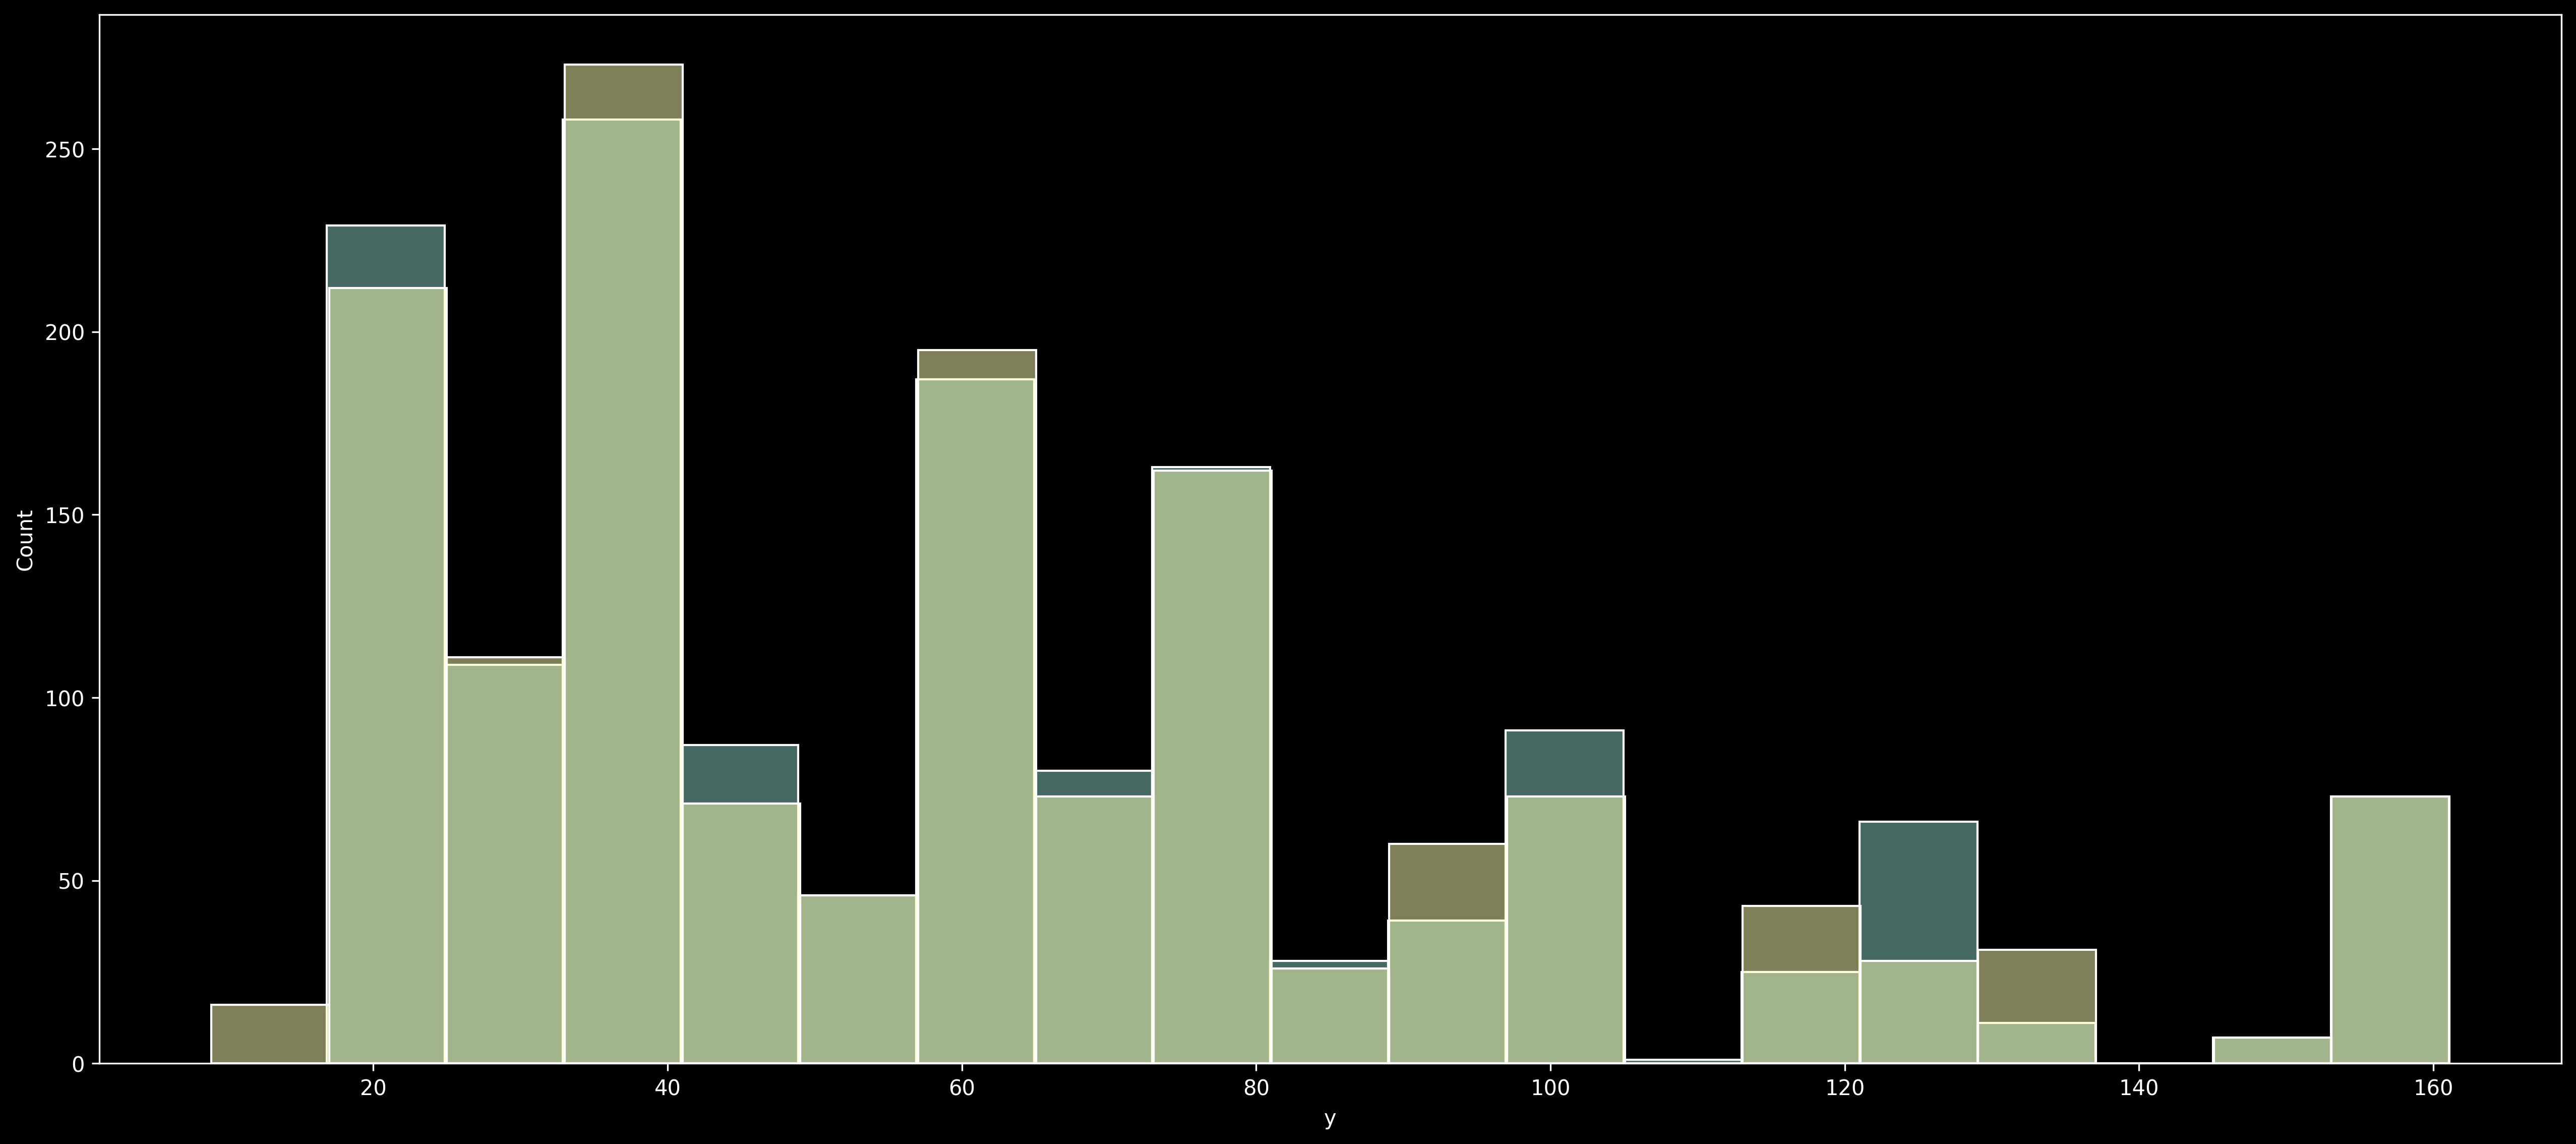

In [25]:
sns.histplot(model.predict(valid_X), alpha=0.5)
sns.histplot(valid_y, alpha=0.5)

# Encoding

In [21]:
# one hot encoding
train = pd.get_dummies(train, columns=CATS)
test = pd.get_dummies(test, columns=CATS)
train_X, valid_X, train_y, valid_y = train_test_split(train.drop("y", axis=1), train["y"], test_size=0.2, random_state=SEED)

In [47]:
display(train)
display(test)

,battery_capacity,mileage,warranty_period,year_of_manufacture,y,manufacturer_0,manufacturer_1,manufacturer_2,manufacturer_3,manufacturer_4,manufacturer_5,manufacturer_6,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10,model_11,model_12,model_13,model_14,model_15,model_16,model_17,model_18,model_19,model_20,vehicle_condition_0,vehicle_condition_1,vehicle_condition_2,drivetrain_0,drivetrain_1,drivetrain_2,accident_history_0,accident_history_1
0,86.077003,13642,0,2,159.66,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False
1,56.000000,10199,6,0,28.01,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False
2,91.199997,2361,7,0,66.27,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False
3,0.000000,21683,3,0,99.16,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False
4,61.018002,178205,1,0,62.02,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7492,0.000000,3773,10,0,35.95,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,True,False
7493,46.000000,135411,2,0,23.40,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,True,False
7494,0.000000,1363,2,0,120.00,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False
7495,56.000000,39445,6,2,24.00,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,True,False


,battery_capacity,mileage,warranty_period,year_of_manufacture,y,manufacturer_0,manufacturer_1,manufacturer_2,manufacturer_3,manufacturer_4,manufacturer_5,manufacturer_6,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10,model_11,model_12,model_13,model_14,model_15,model_16,model_17,model_18,model_19,model_20,vehicle_condition_0,vehicle_condition_1,vehicle_condition_2,drivetrain_0,drivetrain_1,drivetrain_2,accident_history_0,accident_history_1
0,76.093002,14057,2,0,NaN,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False
1,90.000000,7547,8,0,NaN,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False
2,0.000000,7197,7,0,NaN,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True
3,68.478996,10357,7,1,NaN,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False
4,0.000000,7597,10,0,NaN,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,64.682999,117298,2,0,NaN,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,True,False
842,55.547001,72308,0,0,NaN,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,True,False
843,55.547001,124537,0,0,NaN,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,True,False
844,69.646004,15629,4,0,NaN,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False


In [58]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb, time

model = XGBRegressor(
    n_estimators=100,
    objective="reg:squarederror",
    random_state=SEED,
    tree_method='gpu_hist',
    gpu_id=0,
    predictor="gpu_predictor",
    verbose=0
)
model = LGBMRegressor(
    n_estimators=100,
    random_state=SEED,
    device="gpu",
    gpu_device_id=0,
)

In [51]:
FOLD = 5
kf = KFold(n_splits=FOLD, shuffle=True, random_state=SEED)
oof = np.zeros(len(train))
pred = np.zeros(len(test))
rmse_list = []

for trn_idx, val_idx in kf.split(train):
    X_train, X_val = train.iloc[trn_idx], train.iloc[val_idx]
    y_train, y_val = train['y'].iloc[trn_idx], train['y'].iloc[val_idx]
    
    model.fit(X_train, y_train)
    oof[val_idx] = model.predict(X_val)
    pred += model.predict(test) / FOLD
    
    rmse = root_mean_squared_error(y_val, oof[val_idx])
    rmse_list.append(rmse)

print(f"RMSE: {np.mean(rmse_list)}")

[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 5997, number of used features: 41
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.05 MB) transferred to GPU in 0.001008 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 62.221487
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 693
[LightGBM] [Info] Number of data points in

In [48]:
rmse

0.2249572735820447

In [68]:
pred.shape, test.shape

((846,), (846, 10))

In [69]:
submission = pd.read_csv('sample_submission.csv')
submission['가격(백만원)'] = pred
submission.to_csv('submission.csv', index=False)